In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D , Flatten , Input, Dropout, MaxPool2D, BatchNormalization, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR '] = '/content'

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arunrk7/surface-crack-detection

 95% 221M/233M [00:03<00:00, 127MB/s]
100% 233M/233M [00:03<00:00, 79.4MB/s]


In [ ]:
import zipfile
Zipped_File = '/content/surface-crack-detection.zip'
target_dir = '/content/dataset/'
zfile = zipfile.ZipFile(Zipped_File)
zfile.extractall(target_dir)

In [ ]:
Dir_Positive = Path('/content/dataset/Positive')  #Contains Cracks
Dir_Negative = Path('/content/dataset/Negative')  #No Cracks
Pos_filepaths = os.listdir(Dir_Positive)
Neg_filepaths = os.listdir(Dir_Negative)
for i in Dir_Positive , Dir_Negative:
  print(f'samples of {i}',Pos_filepaths[:10])

samples of /content/dataset/Positive ['09916.jpg', '19430.jpg', '02844.jpg', '01237.jpg', '16692_1.jpg', '16714_1.jpg', '13286_1.jpg', '05293.jpg', '00990.jpg', '11377_1.jpg']
samples of /content/dataset/Negative ['09916.jpg', '19430.jpg', '02844.jpg', '01237.jpg', '16692_1.jpg', '16714_1.jpg', '13286_1.jpg', '05293.jpg', '00990.jpg', '11377_1.jpg']


In [ ]:
full_path_pos = [os.path.join(Dir_Positive, img) for img in Pos_filepaths]
full_path_neg = [os.path.join(Dir_Negative, img) for img in Neg_filepaths]
for i in full_path_pos , full_path_neg:
  print('Full path of the image is: ',i[0])

Full path of the image is:  /content/dataset/Positive/09916.jpg
Full path of the image is:  /content/dataset/Negative/09916.jpg


In [ ]:
#list(map(lambda x: os.path.split(x) , list(Dir_Positive.glob(r'*.jpg')))) # to split path from file name
list(Dir_Positive.glob(r'*.jpg')) # to print the full path

[PosixPath('/content/dataset/Positive/09916.jpg'),
 PosixPath('/content/dataset/Positive/19430.jpg'),
 PosixPath('/content/dataset/Positive/02844.jpg'),
 PosixPath('/content/dataset/Positive/01237.jpg'),
 PosixPath('/content/dataset/Positive/16692_1.jpg'),
 PosixPath('/content/dataset/Positive/16714_1.jpg'),
 PosixPath('/content/dataset/Positive/13286_1.jpg'),
 PosixPath('/content/dataset/Positive/05293.jpg'),
 PosixPath('/content/dataset/Positive/00990.jpg'),
 PosixPath('/content/dataset/Positive/11377_1.jpg'),
 PosixPath('/content/dataset/Positive/17395_1.jpg'),
 PosixPath('/content/dataset/Positive/19381.jpg'),
 PosixPath('/content/dataset/Positive/05353.jpg'),
 PosixPath('/content/dataset/Positive/08407.jpg'),
 PosixPath('/content/dataset/Positive/15351_1.jpg'),
 PosixPath('/content/dataset/Positive/00162.jpg'),
 PosixPath('/content/dataset/Positive/19842.jpg'),
 PosixPath('/content/dataset/Positive/17027_1.jpg'),
 PosixPath('/content/dataset/Positive/18744_1.jpg'),
 PosixPath('/co

In [ ]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
positive_df = generate_df(Dir_Positive, label="POSITIVE")
negative_df = generate_df(Dir_Negative, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/content/dataset/Positive/01186.jpg,POSITIVE
1,/content/dataset/Positive/08530.jpg,POSITIVE
2,/content/dataset/Positive/14056_1.jpg,POSITIVE
3,/content/dataset/Negative/15175.jpg,NEGATIVE
4,/content/dataset/Positive/03938.jpg,POSITIVE
...,...,...
39995,/content/dataset/Positive/09499.jpg,POSITIVE
39996,/content/dataset/Negative/17589.jpg,NEGATIVE
39997,/content/dataset/Positive/02498.jpg,POSITIVE
39998,/content/dataset/Positive/06143.jpg,POSITIVE


In [ ]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential()
Input(shape=(120, 120, 3))
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = (120, 120, 3)))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

#DenseLayers
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)     

In [ ]:
opt = Adam(lr=1e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) 
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[ tf.keras.callbacks.EarlyStopping( monitor='val_loss',patience=3, restore_best_weights=True )])

Epoch 1/100
105/105 [==============================] - 17s 63ms/step - loss: 0.4243 - accuracy: 0.8098 - val_loss: 0.6293 - val_accuracy: 0.9286
Epoch 2/100
105/105 [==============================] - 6s 60ms/step - loss: 0.2158 - accuracy: 0.9214 - val_loss: 0.5431 - val_accuracy: 0.9524
Epoch 3/100
105/105 [==============================] - 6s 59ms/step - loss: 0.1657 - accuracy: 0.9423 - val_loss: 0.4242 - val_accuracy: 0.9560
Epoch 4/100
105/105 [==============================] - 6s 59ms/step - loss: 0.1393 - accuracy: 0.9491 - val_loss: 0.2780 - val_accuracy: 0.9655
Epoch 5/100
105/105 [==============================] - 6s 59ms/step - loss: 0.1208 - accuracy: 0.9568 - val_loss: 0.1643 - val_accuracy: 0.9667
Epoch 6/100
105/105 [==============================] - 6s 59ms/step - loss: 0.1032 - accuracy: 0.9619 - val_loss: 0.1075 - val_accuracy: 0.9738
Epoch 7/100
105/105 [==============================] - 6s 60ms/step - loss: 0.0935 - accuracy: 0.9685 - val_loss: 0.0830 - val_accuracy

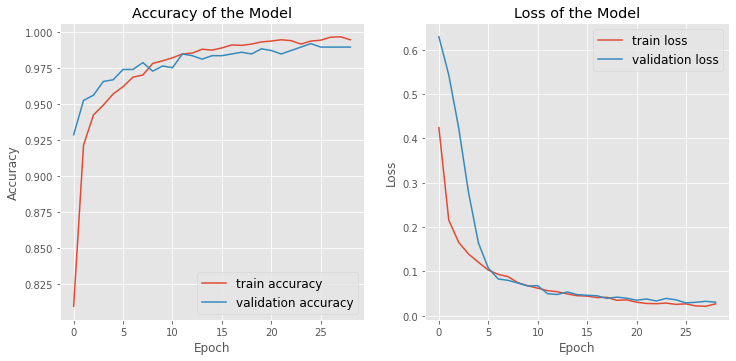

In [ ]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = model.predict(train_data)
predictions

105/105 [==============================] - 5s 41ms/step


array([[0.00542599, 0.994574  ],
       [0.0404674 , 0.95953256],
       [0.07436325, 0.92563677],
       ...,
       [0.9956334 , 0.00436653],
       [0.9946748 , 0.00532524],
       [0.9931625 , 0.00683754]], dtype=float32)

In [ ]:
#cm = confusion_matrix(test_data.labels, predictions)
#clr = classification_report(test_data.labels, predictions, target_names=["NEGATIVE", "POSITIVE"])

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/SavedModels/my CNN Model.h5')
model.save('/content/drive/MyDrive/SavedModels/my CNN Model.hdf5')